In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle
%matplotlib inline

In [7]:
renewables_url = 'https://opendata.arcgis.com/datasets/8abcbea47e7e4faa898a602028efcf4d_98.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
df = pd.read_csv(renewables_url)

In [8]:
df.head()

,X,Y,OBJECTID,NAME,PMT_NBR,REFERENCE_POINT,CHANGED_DATE,CHANGED_BY,VERIFYDATE,VERIFIEDBY,INSERTED_DATE,INSERTED_BY,PERM_ID,PERM_NUM,PERM_NAME,PERM_TOTAL_ACRES,PTC_DESCRIPTION,CLAS_DESCRIPTION,FAC_L_ADDR_1,FAC_L_ADDR_2,FAC_LOCATION,FAC_FIC_COUNTY,COUNTY,REGION,RECOMCOM,PERMIT_STATUS,SEC130,PERM_MW
0,-8.872598e+06,4.389143e+06,1,NaN,RE0000111,FC,2019/12/03 11:06:55+00,SMTRIPP,2019/12/03 11:06:55+00,SMTRIPP,2019/10/25 15:05:32+00,SMTRIPP,7.500000e+11,RE0000111,Caden Energix Axton LLC,550.0,Solar,NOI - Active,NaN,NaN,NaN,89.0,Henry County,West Central Regional Office,Not Producing,Solar NOI - Active Not Producing,N,NaN
1,-8.671789e+06,4.641771e+06,2,NaN,RE0000123,PG,2019/10/28 15:25:06+00,SMTRIPP,2019/10/28 15:25:06+00,SMTRIPP,2019/10/28 15:25:06+00,SMTRIPP,7.500000e+11,RE0000123,"Greenwood Solar I, LLC",1000.0,Solar,Permit - Active,NaN,NaN,NaN,47.0,Culpeper County,Northern Regional Office,Not Producing,Solar Permit - Active Not Producing,N,NaN
2,-8.593974e+06,4.533168e+06,3,NaN,RE0000046,PG,2019/11/01 14:29:06+00,SMTRIPP,2019/11/01 14:29:05+00,SMTRIPP,2019/11/01 14:23:32+00,SMTRIPP,7.500000e+11,RE0000046,"Sweetspire, LLC",165.0,Solar,NOI - Active,NaN,NaN,NaN,85.0,Hanover County,Piedmont Regional Office,Not Producing,Solar NOI - Active Not Producing,N,NaN
3,-8.529313e+06,4.477204e+06,4,NaN,RE0000130,PG,2019/11/07 12:20:02+00,SMTRIPP,2019/11/07 12:20:01+00,SMTRIPP,2019/11/07 12:20:02+00,SMTRIPP,7.500000e+11,RE0000130,"KDC Solar Kings Creek, LLC",395.0,Solar,Permit - Active,1801 Penniman Rd,NaN,NaN,95.0,James City County,Tidewater Regional Office,Not Producing,Solar Permit - Active Not Producing,Y,NaN
4,-8.527930e+06,4.580323e+06,5,NaN,RE0000043,PG,2019/11/08 16:48:51+00,SMTRIPP,2019/11/08 16:48:50+00,SMTRIPP,2019/11/08 16:44:49+00,SMTRIPP,7.500000e+11,RE0000043,"Gardy's Mill Solar, LLC",199.0,Solar,Permit - Active,1079 Gardy's Mill Rd,NaN,"Parcel ID: 55 112, 55 114, 55 115\n\n38.007338...",193.0,Westmoreland County,Piedmont Regional Office,Not Producing,Solar Permit - Active Not Producing,N,NaN


In [9]:
df.shape

(163, 28)

In [14]:
df_cleaned = df.dropna(subset=['COUNTY'])
# df_cleaned["Full_Address"] = df_cleaned.apply(lambda row: row.FAC_L_ADDR_1 + "," + row.COUNTY + ",VA,United States", axis=1)
df_cleaned["Minimal_Address"] = df_cleaned.apply(lambda row: row.COUNTY + ",VA,United States", axis=1)
# df_cleaned = df_cleaned.drop_duplicates(subset=['Full_Address'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df_cleaned.shape

(160, 29)

In [16]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="my_user_agent")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.1)

In [17]:
def lat_long_converter(geocode, minimum_address):
  loc = geocode(minimum_address)
  if not loc:
    return None
  loc = tuple(loc.point)
  lat_bound = loc[0] < 36 or loc[0] > 39.5
  long_bound = loc[1] < -84 or loc[1] > -75
  if lat_bound or long_bound:
    return None
  else:
    return loc 

In [19]:
df_cleaned["coordinate"] = df_cleaned.apply(lambda row: lat_long_converter(geocode, row.Minimal_Address), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [21]:
df_cleaned = df_cleaned.dropna(subset=['coordinate'])
df_cleaned[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_cleaned['coordinate'].tolist(), index=df_cleaned.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
df_cleaned.head()

,X,Y,OBJECTID,NAME,PMT_NBR,REFERENCE_POINT,CHANGED_DATE,CHANGED_BY,VERIFYDATE,VERIFIEDBY,INSERTED_DATE,INSERTED_BY,PERM_ID,PERM_NUM,PERM_NAME,PERM_TOTAL_ACRES,PTC_DESCRIPTION,CLAS_DESCRIPTION,FAC_L_ADDR_1,FAC_L_ADDR_2,FAC_LOCATION,FAC_FIC_COUNTY,COUNTY,REGION,RECOMCOM,PERMIT_STATUS,SEC130,PERM_MW,Minimal_Address,coordinate,latitude,longitude,altitude
1,-8.671789e+06,4.641771e+06,2,NaN,RE0000123,PG,2019/10/28 15:25:06+00,SMTRIPP,2019/10/28 15:25:06+00,SMTRIPP,2019/10/28 15:25:06+00,SMTRIPP,7.500000e+11,RE0000123,"Greenwood Solar I, LLC",1000.0,Solar,Permit - Active,NaN,NaN,NaN,47.0,Culpeper County,Northern Regional Office,Not Producing,Solar Permit - Active Not Producing,N,NaN,"Culpeper County,VA,United States","(38.4912207, -77.9618216, 0.0)",38.491221,-77.961822,0.0
2,-8.593974e+06,4.533168e+06,3,NaN,RE0000046,PG,2019/11/01 14:29:06+00,SMTRIPP,2019/11/01 14:29:05+00,SMTRIPP,2019/11/01 14:23:32+00,SMTRIPP,7.500000e+11,RE0000046,"Sweetspire, LLC",165.0,Solar,NOI - Active,NaN,NaN,NaN,85.0,Hanover County,Piedmont Regional Office,Not Producing,Solar NOI - Active Not Producing,N,NaN,"Hanover County,VA,United States","(37.744783, -77.4464165, 0.0)",37.744783,-77.446416,0.0
3,-8.529313e+06,4.477204e+06,4,NaN,RE0000130,PG,2019/11/07 12:20:02+00,SMTRIPP,2019/11/07 12:20:01+00,SMTRIPP,2019/11/07 12:20:02+00,SMTRIPP,7.500000e+11,RE0000130,"KDC Solar Kings Creek, LLC",395.0,Solar,Permit - Active,1801 Penniman Rd,NaN,NaN,95.0,James City County,Tidewater Regional Office,Not Producing,Solar Permit - Active Not Producing,Y,NaN,"James City County,VA,United States","(37.3211485, -76.7972515, 0.0)",37.321148,-76.797252,0.0
7,-8.410712e+06,4.574051e+06,8,Eastern Shore Solar LLC,RE0000001,FC,2020/10/02 10:51:29+00,SMTRIPP,2020/10/02 10:51:29+00,SMTRIPP,1970/01/01 00:00:00+00,NaN,7.500000e+11,RE0000001,"Eastern Shore Solar, LLC",1000.0,Solar,Permit - Active,NaN,NaN,NaN,1.0,Accomack County,Tidewater Regional Office,Producing,Solar Permit - Active Producing,N,NaN,"Accomack County,VA,United States","(37.7422207, -75.6743538, 0.0)",37.742221,-75.674354,0.0
8,-8.528146e+06,4.515320e+06,9,NaN,RE0000145,FC,2019/12/02 10:24:28+00,SMTRIPP,2019/12/02 10:24:28+00,SMTRIPP,2019/12/02 10:24:28+00,SMTRIPP,7.500000e+11,RE0000145,Carvers Creek Solar,1734.0,Solar,Permit - Active,NaN,NaN,NaN,73.0,Gloucester County,Piedmont Regional Office,Not Producing,Solar Permit - Active Not Producing,N,NaN,"Gloucester County,VA,United States","(37.4452288, -76.5594479, 0.0)",37.445229,-76.559448,0.0


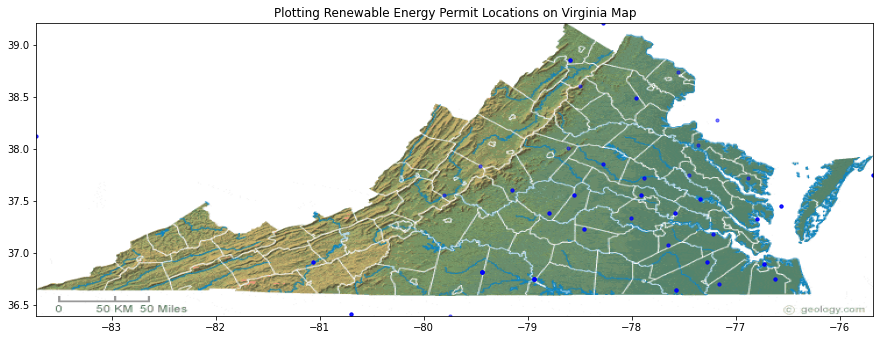

In [24]:
ruh_m = plt.imread('virginia-physical-map.gif')
BBox = ((df_cleaned.longitude.min(),   df_cleaned.longitude.max(),      
         df_cleaned.latitude.min(), df_cleaned.latitude.max()))

fig, ax = plt.subplots(figsize = (15, 15))
ax.scatter(df_cleaned.longitude, df_cleaned.latitude, zorder=1, alpha= 0.5, c='b', s=10)
ax.set_title('Plotting Renewable Energy Permit Locations on Virginia Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [27]:
df_final = df_cleaned[["PERM_NAME", "PTC_DESCRIPTION", "COUNTY", "Minimal_Address", "latitude", "longitude"]]
df_final.to_pickle("renewable_energy.pkl")